# Mobile App Rate Classifier

## PROJECT GOAL

The main purpose of the project is to classify mobile app into correct rating category basing on app description and other provided features. The idea to obtain good results is to create various statistical models and compare the accuracy score.  
Used data comes from Kaggle website. The data is divided into two data frames. Generally, the first one contains various categorical and numerical variables and target feature in raw form (before binarisation), the second contains apps descriptions. 

## DATASETS DESCRIPTION
The data was extracted from Apple Inc in July 2017 and includes 7197 observations and 17 variables. 
appleStore.csv
+ "id" : App ID
+ "track_name": App Name
+ "size_bytes": Size (in Bytes)
+ "currency": Currency Type
+ "price": Price amount
+ "rating_count_tot": User Rating counts (for all version)
+ "rating_count_ver": User Rating counts (for current version)
+ "user_rating" : Average User Rating value (for all version)
+ "user_rating_ver": Average User Rating value (for current version)
+ "ver" : Latest version code
+ "cont_rating": Content Rating
+ "prime_genre": Primary Genre
+ "sup_devices.num": Number of supporting devices
+ "ipadSc_urls.num": Number of screenshots showed for display
+ "lang.num": Number of supported languages
+ "vpp_lic": Vpp Device Based Licensing Enabled

appleStore_description.csv
+ id : App ID
+ track_name: Application name
+ size_bytes: Memory size (in Bytes)
+ app_desc: Application description

## IMPORT LIBRARIES

In [110]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
import plotly.graph_objs as go

%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from scipy import sparse
import scipy.stats as ss

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package stopwords to /home/adam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## DATA EXPLORATION

In [114]:
store = pd.read_csv('AppleStore.csv', index_col=0)
description = pd.read_csv('appleStore_description.csv')

In [115]:
store.head()

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [116]:
description.head()

,id,track_name,size_bytes,app_desc
0,281656475,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,Download the most popular free weather app pow...
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,The eBay app is the best way to find anything ...
4,282935706,Bible,92774400,On more than 250 million devices around the wo...


In [117]:
df = store.merge(description, on=["id", "track_name", "size_bytes"])
del store
del description

Change user rating variable into binary.

In [118]:
df["target"] = df["user_rating"].apply(lambda x: 1 if x >= 4 else 0)

In [119]:
df.shape

(7197, 18)

In [120]:
df.describe(include='all')

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc,target
count,7.197000e+03,7197,7.197000e+03,7197,7197.000000,7.197000e+03,7197.000000,7197.000000,7197.000000,7197,7197,7197,7197.000000,7197.000000,7197.000000,7197.000000,7197,7197.000000
unique,NaN,7195,NaN,1,NaN,NaN,NaN,NaN,NaN,1590,4,23,NaN,NaN,NaN,NaN,7147,NaN
top,NaN,Mannequin Challenge,NaN,USD,NaN,NaN,NaN,NaN,NaN,1.0,4+,Games,NaN,NaN,NaN,NaN,Escape from here! \n\nTap on the objects in th...,NaN
freq,NaN,2,NaN,7197,NaN,NaN,NaN,NaN,NaN,317,4433,3862,NaN,NaN,NaN,NaN,5,NaN
mean,8.631310e+08,NaN,1.991345e+08,NaN,1.726218,1.289291e+04,460.373906,3.526956,3.253578,NaN,NaN,NaN,37.361817,3.707100,5.434903,0.993053,NaN,0.664305
std,2.712368e+08,NaN,3.592069e+08,NaN,5.833006,7.573941e+04,3920.455183,1.517948,1.809363,NaN,NaN,NaN,3.737715,1.986005,7.919593,0.083066,NaN,0.472266
min,2.816565e+08,NaN,5.898240e+05,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,NaN,9.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,6.000937e+08,NaN,4.692275e+07,NaN,0.000000,2.800000e+01,1.000000,3.500000,2.500000,NaN,NaN,NaN,37.000000,3.000000,1.000000,1.000000,NaN,0.000000
50%,9.781482e+08,NaN,9.715302e+07,NaN,0.000000,3.000000e+02,23.000000,4.000000,4.000000,NaN,NaN,NaN,37.000000,5.000000,1.000000,1.000000,NaN,1.000000
75%,1.082310e+09,NaN,1.819249e+08,NaN,1.990000,2.793000e+03,140.000000,4.500000,4.500000,NaN,NaN,NaN,38.000000,5.000000,8.000000,1.000000,NaN,1.000000


The above table shows:
+ dataset has no NA values
+ there are two duplicates in app name (duplicates should be removed)
+ currency for all apps is the same (variable should be removed)
+ there is 1590 unique values in ver (version) variable (feature transformation needed)
+ most frequent app genre is "Game" - 4433 occurences (feature transformation needed)

### DATA VISUALISATION

#### Dependant variable class counts

4781 of observation is from class 1 and 2416 from class 0.

In [121]:
target_count = df["target"].value_counts()
data = [go.Bar(
    x=target_count.index, 
    y=target_count.values,
    opacity=0.75,
    marker=dict(
        color='rgb(0, 51, 102)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        )
    ))]
layout = go.Layout(title="Target class counts",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   yaxis={'title': "Count"},
                   hovermode="closest")
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Byte size

Apps with higher rate tend to have bigger size as well.

In [122]:
target_0 = go.Histogram(x=np.log(df[df["target"] == 0]["size_bytes"]),
                        opacity=0.75,
                        name="target 0",
                        marker=dict(
                            color='rgb(0, 51, 102)',
                            line=dict(
                                color='rgb(0,0,0)',
                                width=1.5,
                            )))
target_1 = go.Histogram(x=np.log(df[df["target"] == 1]["size_bytes"]),
                        opacity=0.55,
                        name="target 1",
                        marker=dict(
                            color='rgb(255, 153, 0)',
                            line=dict(
                                color='rgb(0,0,0)',
                                width=1.5,
                            )))
layout = go.Layout(title="Size in bytes",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   barmode="overlay")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Price

Non Free apps have slighty higher class 1 share.

In [123]:
df['isFree'] = df["price"].apply(lambda x: 1 if x == 0 else 0)
price_impact = df[["isFree", "target"]].pivot_table(index="isFree", values="isFree", columns="target", aggfunc="size")

target_0 = go.Bar(
    x=price_impact.index,
    y=price_impact[0],
    name='target 0',
    opacity=0.75,
    marker=dict(
        color='rgb(0, 51, 102)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        ))
    
)
target_1 = go.Bar(
    x=price_impact.index,
    y=price_impact[1],
    name='target 1',
    opacity=0.55,
    marker=dict(
        color='rgb(255, 153, 0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        ))
)
layout = go.Layout(title="Price impact",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   xaxis={'title': "IsFree"},
                   barmode="stack")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Total rating count

Apps with less rating count tend to have lower rate as well.

In [124]:
target_0 = go.Histogram(x=np.log(df[df["target"] == 0]["rating_count_tot"] + 1),
                        opacity=0.75,
                        name="target 0",
                        marker=dict(
                            color='rgb(0, 51, 102)',
                            line=dict(
                                color='rgb(0,0,0)',
                                width=1.5,
                            )))
target_1 = go.Histogram(x=np.log(df[df["target"] == 1]["rating_count_tot"] + 1),
                        opacity=0.55,
                        name="target 1",
                        marker=dict(
                            color='rgb(255, 153, 0)',
                            line=dict(
                                color='rgb(0,0,0)',
                                width=1.5,
                            )))
layout = go.Layout(title="Total rating count",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   barmode="overlay")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Total rating count ver

Apps with less rating count varsion tend to have lower rate as well.

In [126]:
target_0 = go.Histogram(x=np.log(df[df["target"] == 0]["rating_count_ver"] + 1),
                        opacity=0.75,
                        name="target 0",
                        marker=dict(
                            color='rgb(0, 51, 102)',
                            line=dict(
                                color='rgb(0,0,0)',
                                width=1.5,
                            )))
target_1 = go.Histogram(x=np.log(df[df["target"] == 1]["rating_count_ver"] + 1),
                        opacity=0.55,
                        name="target 1",
                        marker=dict(
                            color='rgb(255, 153, 0)',
                            line=dict(
                                color='rgb(0,0,0)',
                                width=1.5,
                            )))
layout = go.Layout(title="Version rating count histogram",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   barmode="overlay")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### User rating ver

Apps with higher last version rate tend to have higher class 1 share.

In [127]:
last_ver = df[["user_rating_ver", "target"]].pivot_table(index="user_rating_ver", values="user_rating_ver", columns="target", aggfunc="size")

target_0 = go.Bar(
    x=last_ver.index,
    y=last_ver[0],
    opacity=0.55,
    name='target 0',
    marker=dict(
    color='rgb(0, 51, 102)',
    line=dict(
        color='rgb(0,0,0)',
        width=1.5,
    ))
)
target_1 = go.Bar(
    x=last_ver.index,
    y=last_ver[1],
    name='target 1',
    opacity=0.55,
    marker=dict(
        color='rgb(255, 153, 0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        ))
)
layout = go.Layout(title="Last version rating",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   xaxis={'title': "Rating"},
                   barmode="stack")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Ver (version)

The is no visual diferences between different app generation.

In [128]:
# Create new feature by extracting app generation
def version(x):
    if x[:1] == "1":
        return "ver 1"
    elif x[:1] == "2":
        return "ver 2"
    elif x[:1] == "3":
        return "ver 3"
    else:
        return"ver 4+"

df['version'] = df["ver"].apply(version)
version_impact = df[["version", "target"]].pivot_table(index="version", values="version", columns="target", aggfunc="size")

target_0 = go.Bar(
    x=version_impact.index,
    y=version_impact[0],
    name='target 0',
    opacity=0.55,
    marker=dict(
    color='rgb(0, 51, 102)',
    line=dict(
        color='rgb(0,0,0)',
        width=1.5,
    ))
)
target_1 = go.Bar(
    x=version_impact.index,
    y=version_impact[1],
    name='target 1',
    opacity=0.55,
    marker=dict(
        color='rgb(255, 153, 0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        ))
)
layout = go.Layout(title="Last version rating distribution",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   xaxis={'title': "Rating"},
                   barmode="stack")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Cont rating

Apps for elder audience tend to have lower class 1 share.

In [129]:
cont_rating_impact = df[["cont_rating", "target"]].pivot_table(index="cont_rating", values="cont_rating", columns="target", aggfunc="size")

target_0 = go.Bar(
    x=cont_rating_impact.index,
    y=cont_rating_impact[0],
    name='target 0',
    opacity=0.55,
    marker=dict(
    color='rgb(0, 51, 102)',
    line=dict(
        color='rgb(0,0,0)',
        width=1.5,
    ))
)
target_1 = go.Bar(
    x=cont_rating_impact.index,
    y=cont_rating_impact[1],
    name='target 1',
    opacity=0.55,
    marker=dict(
        color='rgb(255, 153, 0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        ))
)
layout = go.Layout(title="Content rating",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   xaxis={'title': "Content rating"},
                   barmode="stack")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Prime genre

Games are the majority of genres. 

In [130]:
prime_genre_impact = df[["prime_genre", "target"]].pivot_table(index="prime_genre", values="prime_genre", columns="target", aggfunc="size")

target_0 = go.Bar(
    x=prime_genre_impact.index,
    y=prime_genre_impact[0],
    name='target 0',
    opacity=0.55,
    marker=dict(
    color='rgb(0, 51, 102)',
    line=dict(
        color='rgb(0,0,0)',
        width=1.5,
    ))
)
target_1 = go.Bar(
    x=prime_genre_impact.index,
    y=prime_genre_impact[1],
    name='target 1',
    opacity=0.55,
    marker=dict(
        color='rgb(255, 153, 0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        ))
)
layout = go.Layout(title="Prime Genre",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   xaxis={'title': "Prime Genre"},
                   barmode="stack")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Sup devices

Most of the apps support more 36 devices. The median for each class is almost equal.

In [131]:
sup_devices_num_impact = df[["sup_devices.num", "target"]].pivot_table(index="sup_devices.num", values="sup_devices.num", columns="target", aggfunc="size")

target_0 = go.Bar(
    x=sup_devices_num_impact.index,
    y=sup_devices_num_impact[0],
    name='target 0',
    opacity=0.55,
    marker=dict(
    color='rgb(0, 51, 102)',
    line=dict(
        color='rgb(0,0,0)',
        width=1.5,
    ))
)
target_1 = go.Bar(
    x=sup_devices_num_impact.index,
    y=sup_devices_num_impact[1],
    name='target 1',
    opacity=0.55,
    marker=dict(
        color='rgb(255, 153, 0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        ))
)
layout = go.Layout(title="Supported devices",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   xaxis={'title': "Number of supported devices"},
                   barmode="stack")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

In [132]:
target_0 = go.Box(
    y=df[df["target"] == 0]["sup_devices.num"],
    name='target 0'
)
target_1 = go.Box(
    y=df[df["target"] == 1]["sup_devices.num"],
    name='target 1'
)
layout = go.Layout(title="Supported devices",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   xaxis={'title': "Number of supported devices"},
                   barmode="stack")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Number of supported screen

Apps which support more screen tend to have higher class 1 share.

In [133]:
ipadSc_urls_num_impact = df[["ipadSc_urls.num", "target"]].pivot_table(index="ipadSc_urls.num", values="ipadSc_urls.num", columns="target", aggfunc="size")

target_0 = go.Bar(
    x=ipadSc_urls_num_impact.index,
    y=ipadSc_urls_num_impact[0],
    name='target 0',
    opacity=0.55,
    marker=dict(
    color='rgb(0, 51, 102)',
    line=dict(
        color='rgb(0,0,0)',
        width=1.5,
    ))
)
target_1 = go.Bar(
    x=ipadSc_urls_num_impact.index,
    y=ipadSc_urls_num_impact[1],
    name='target 1',
    opacity=0.55,
    marker=dict(
        color='rgb(255, 153, 0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        ))
    
)
layout = go.Layout(title="Number of supported screen",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   xaxis={'title': "Number of supported screen"},
                   barmode="stack")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Numer of supported languages

Apps with more supported languages tend to have higher class 1 share.

In [134]:
target_0 = go.Box(
    y=df[df["target"] == 0]["lang.num"],
    name='target 0'
)
target_1 = go.Box(
    y=df[df["target"] == 1]["lang.num"],
    name='target 1'
)
layout = go.Layout(title="Numer of supported languages",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   xaxis={'title': "Numer of supported languages"},
                   barmode="stack")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Vpp Device Based Licensing Enabled

Majority of observations have enabled Vpp Device Based Licensing. This variable should be excluded from analysis.

In [135]:
vpp_lic_impact = df[["vpp_lic", "target"]].pivot_table(index="vpp_lic", values="vpp_lic", columns="target", aggfunc="size")

target_0 = go.Bar(
    x=vpp_lic_impact.index,
    y=vpp_lic_impact[0],
    name='target 0',
    opacity=0.55,
    marker=dict(
    color='rgb(0, 51, 102)',
    line=dict(
        color='rgb(0,0,0)',
        width=1.5,
    ))
)
target_1 = go.Bar(
    x=vpp_lic_impact.index,
    y=vpp_lic_impact[1],
    name='target 1',
    opacity=0.55,
    marker=dict(
        color='rgb(255, 153, 0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        ))
)
layout = go.Layout(title="Vpp Device Based Licensing Enabled",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   xaxis={'title': "Vpp Device Based Licensing Enabled"},
                   barmode="stack")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Description

Apps with longer description tend to have higher class 1 share.

In [136]:
df["lenght"] = df["app_desc"].apply(lambda x: len(x))
target_0 = go.Histogram(x=np.log(df[df["target"] == 0]["lenght"] + 1),
                        opacity=0.75,
                        name="target 0",
                        marker=dict(
                            color='rgb(0, 51, 102)',
                            line=dict(
                                color='rgb(0,0,0)',
                                width=1.5,
                            )))
target_1 = go.Histogram(x=np.log(df[df["target"] == 1]["lenght"] + 1),
                        opacity=0.55,
                        name="target 1",
                        marker=dict(
                            color='rgb(255, 153, 0)',
                            line=dict(
                                color='rgb(0,0,0)',
                                width=1.5,
                            )))
layout = go.Layout(title="Description lenght",
                   titlefont=dict(
                        size=20,
                        color='rgb(0, 0, 0)'
                    ),
                   barmode="overlay")
data = [target_0, target_1]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

#### Most frequent words

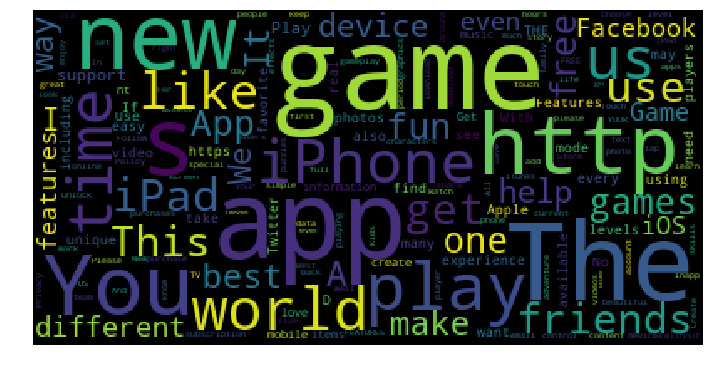

In [137]:
descriptions = df["app_desc"].str.cat(sep=" ")
tokens = word_tokenize(descriptions)
stop_words = set(stopwords.words('english'))
tokens = [re.sub("[^a-zA-Z]", "", w) for w in tokens if not w in stop_words]
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## DATA PREPROCESSING

In [138]:
df["isFree"] = df["price"].apply(lambda x: 1 if x == 0 else 0)
df["isGame"] = df["prime_genre"].apply(lambda x: 1 if x == "Game" else 0)
df.index = df["id"]

In [139]:
df.columns

Index(['id', 'track_name', 'size_bytes', 'currency', 'price',
       'rating_count_tot', 'rating_count_ver', 'user_rating',
       'user_rating_ver', 'ver', 'cont_rating', 'prime_genre',
       'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic', 'app_desc',
       'target', 'isFree', 'version', 'lenght', 'isGame'],
      dtype='object')

In [140]:
df.columns = ["id", "track_name", "size", "currency", "price", "n_rating_tot", "n_rating_ver", "rating_tot",
              "rating_ver", 'ver', "content_cat", "genre", "n_devices", "n_screen", "n_lang", "vpp_lic", 
              "description", "target", "isFree", "version", "len", "isGame"]

In [141]:
df["content_cat"] = df["content_cat"].astype("category")
df["version"] = df["version"].astype("category")

#### Train, validation, test split

In [142]:
X = df.drop(labels="target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

X_train_text = X_train["description"] 
X_val_text = X_val["description"] 
X_test_text = X_test["description"]

X_train_cn = X_train.drop("description", axis=1)
X_val_cn = X_val.drop("description", axis=1)
X_test_cn = X_test.drop("description", axis=1)

In [143]:
# Check the new datasets shape
print(X_train_cn.shape)
print(X_val_cn.shape)
print(X_test_cn.shape)
print(X_train_text.shape)
print(X_val_text.shape)
print(X_test_text.shape)

(4047, 20)
(1350, 20)
(1800, 20)
(4047,)
(1350,)
(1800,)


In [144]:
class DropColumns(BaseEstimator, TransformerMixin):
    """
    Transformer to drop specified columns.
    """
    
    def __init__(self, columns_to_drop):    
        self.columns_to_drop = columns_to_drop
        if len(self.columns_to_drop) != len(set(self.columns_to_drop)):
            warnings.warn('Warning! Duplicated columns.')
            self.columns_to_drop = list(set(self.columns_to_drop))
               
    def fit(self, X, y=None):
        if not set(self.columns_to_drop).issubset(X.columns):
            words_not_in = set(self.columns_to_drop) - set(X.columns)
            for word in X.columns:
                for other_word in words_not_in:
                    if nltk.edit_distance(word, other_word) < 2:
                        warnings.warn('Word {} not in dataframe. Did you mean {}?'.format(other_word, word))
            raise ValueError('Not all columns are in specified dataframe')
        return self

    def transform(self, X):
        X_new = X.copy()
        return X_new.drop(self.columns_to_drop, axis=1, inplace=False)

    
class ColumnsSelectorByType(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns of specified types.
    """
    
    def __init__(self, types_to_select): 
        self.types_to_select = types_to_select
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.select_dtypes(include = self.types_to_select)  
    
    
def text_process(description):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation and numbers.
    2. Chenge words to lower case.
    3. Stem words.
    4. Remove all stopwords
    5. Returns a list of the cleaned text
    """
    description = re.sub("[^a-zA-Z]", " ", description)
    description = description.lower()
    description = description.split()
    ps = PorterStemmer()
    description = [ps.stem(word) for word in description if not word in set(stopwords.words('english'))]
    return description

#### Pipeline for category and numerilac features

In [145]:
preprocessor = make_pipeline(
    DropColumns(['id', 'track_name', 'currency', 'rating_tot', 'version', 'genre', 'vpp_lic']),
    FeatureUnion([
        ("numeric", make_pipeline(
                        ColumnsSelectorByType("number"),
                        SimpleImputer(strategy="mean"),
                        StandardScaler()
                    )
        ),
        ("categorical", make_pipeline(
                            ColumnsSelectorByType('category'),
                            OneHotEncoder(handle_unknown='ignore', sparse=False)
                        )
        )
    ])
)

In [146]:
preprocessor.fit(X_test_cn)

Pipeline(memory=None,
     steps=[('dropcolumns', DropColumns(columns_to_drop=['id', 'track_name', 'currency', 'rating_tot', 'version', 'genre', 'vpp_lic'])), ('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('columnsselectorbytype', ColumnsSelectorByType(types_...andle_unknown='ignore',
       n_values=None, sparse=False))]))],
       transformer_weights=None))])

In [147]:
X_train_cn = pd.DataFrame(preprocessor.transform(X_train))
X_val_cn = pd.DataFrame(preprocessor.transform(X_val))
X_test_cn = pd.DataFrame(preprocessor.transform(X_test))

In [148]:
X_train_cn.to_csv('X_train_cn.csv')
X_val_cn.to_csv('X_val_cn.csv')
X_test_cn.to_csv('X_test_cn.csv')

In [149]:
X_train_cn = pd.read_csv("X_train_cn.csv", index_col=0)
X_val_cn = pd.read_csv("X_val_cn.csv", index_col=0)
X_test_cn = pd.read_csv("X_test_cn.csv", index_col=0)

#### Text feature processing

In [150]:
cv = CountVectorizer(analyzer=text_process, max_df=0.9, min_df=2)
cv.fit(X_train_text)

CountVectorizer(analyzer=<function text_process at 0x7f4723f3bf28>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=0.9,
        max_features=None, min_df=2, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [ ]:
X_train_text = cv.transform(X_train_text)
X_val_text = cv.transform(X_val_text)
X_test_text = cv.transform(X_test_text)

In [ ]:
sparse.save_npz("X_train_text.npz", X_train_text)
sparse.save_npz("X_val_text.npz", X_val_text)
sparse.save_npz("X_test_text.npz", X_test_text)

In [151]:
X_train_text = sparse.load_npz("X_train_text.npz")
X_val_text = sparse.load_npz("X_val_text.npz")
X_test_text = sparse.load_npz("X_test_text.npz")

#### LDA 

In [ ]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation()
# Init Grid Search Class
model_lda = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model_lda.fit(X_train_text)

In [ ]:
filename = 'lda_model.sav'
pickle.dump(model_lda.best_estimator_, open(filename, 'wb'))

In [153]:
model_lda = pickle.load(open('lda_model.sav', 'rb'))

In [154]:
X_train_lda = model_lda.transform(X_train_text)
X_val_lda = model_lda.transform(X_val_text)
X_test_lda = model_lda.transform(X_test_text)

In [161]:
def join_lda_cn(X, X_lda):
    X_cnlda = X.copy()
    for topic in range(len(X_lda[0])):
        col_name = "topic_{}".format(topic + 1)
        X_cnlda[col_name] = X_lda[:,topic]
    return X_cnlda

In [162]:
X_train_cnlda = join_lda_cn(X_train_cn, X_train_lda)
X_val_cnlda = join_lda_cn(X_val_cn, X_val_lda)
X_test_cnlda = join_lda_cn(X_test_cn, X_test_lda)

# MODELING

#### XGB

In [163]:
def xgb_model(folds, param_comb, X_train, y_train, X_val, y_val, save_file):
    """
    
    """
    
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 123)

    xgb = XGBClassifier(n_jobs=-1, random_state=123)
    params = {"learning_rate":ss.uniform(0.001,0.5),
             "n_estimators":ss.randint(10,1000),
             "max_depth": ss.randint(3,25),
             "min_child_weight":ss.randint(1,15),
             "gamma": ss.randint(0,10),
             "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             "colsample_bytree": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             "reg_lambda":ss.uniform(0.05,5),
             "reg_alpha":ss.uniform(0.05,5)}


    model_xgb =  RandomizedSearchCV(estimator=xgb, 
                                    param_distributions=params, 
                                    n_iter=param_comb, 
                                    scoring='accuracy', 
                                    n_jobs=-1, 
                                    cv=skf.split(X_train, y_train), 
                                    verbose=3, 
                                    random_state=123)

    
    model_xgb.fit(X_train, y_train)
    scores = dict()
    scores["train_dataset"] = {
        "Accuracy": np.round(accuracy_score(model_xgb.best_estimator_.predict(X_train), y_train), 4),
        "AUC": np.round(roc_auc_score(y_train, model_xgb.best_estimator_.predict_proba(X_train)[:, 1]), 4)
      }
    scores["validation_dataset"] = {
        "Accuracy":np.round(accuracy_score(model_xgb.best_estimator_.predict(X_val), y_val), 4),
        "AUC": np.round(roc_auc_score(y_val, model_xgb.best_estimator_.predict_proba(X_val)[:, 1]), 4)
      }
    pickle.dump(model_xgb.best_estimator_, open(save_file, 'wb'))
    return model_xgb, scores

In [ ]:
folds = 5
param_comb = 50

xgb_cn = xgb_model(folds, param_comb, X_train_cn, y_train, X_val_cn, y_val, 'xgb_cn.sav')
xgb_text = xgb_model(folds, param_comb, X_train_text, y_train, X_val_text, y_val, 'xgb_text')
xgb_cnlda = xgb_model(folds, param_comb, X_train_cnlda, y_train, X_test_cnlda, y_test, 'xgb_cnlda.sav')
pd.DataFrame([xgb_cn[1], xgb_text[1], xgb_cnlda[1]], 
             index=["Categorical&Numeric", "Text", "Categorical&Numeric&LDA"])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.3min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.0min


#### Random Forest

In [ ]:
def rf_model(folds, param_comb, X_train, y_train, X_val, y_val, save_file):
    """
    
    """
    
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 123)
    rf = RandomForestClassifier(n_jobs=-1, random_state=123)
    params = {"bootstrap": [True, False],
             "max_depth": ss.randint(3,10),
             "max_features": ['auto', 'sqrt'],
             "min_samples_leaf": ss.randint(1,10),
             "min_samples_split": ss.randint(2,10),
             "n_estimators":ss.randint(10,1000),
             "criterion": ["gini", "entropy"],
             "class_weight": ["balanced", "balanced_subsample", None]
             }

    model_rf =  RandomizedSearchCV(estimator=rf, 
                                    param_distributions=params, 
                                    n_iter=param_comb, 
                                    scoring='accuracy', 
                                    n_jobs=-1, 
                                    cv=skf.split(X_train, y_train), 
                                    verbose=3, 
                                    random_state=123)
    model_rf.fit(X_train, y_train)
    scores = dict()
    scores["train_dataset"] = {
        "Accuracy": np.round(accuracy_score(model_rf.best_estimator_.predict(X_train), y_train), 4),
        "AUC": np.round(roc_auc_score(y_train, model_rf.best_estimator_.predict_proba(X_train)[:, 1]), 4)
      }
    scores["validation_dataset"] = {
        "Accuracy":np.round(accuracy_score(model_rf.best_estimator_.predict(X_val), y_val), 4),
        "AUC": np.round(roc_auc_score(y_val, model_rf.best_estimator_.predict_proba(X_val)[:, 1]), 4)
      }
    pickle.dump(model_rf.best_estimator_, open(save_file, 'wb'))
    return model_rf, scores

In [ ]:
folds = 5
param_comb = 50

rf_cn = rf_model(folds, param_comb, X_train_cn, y_train, X_val_cn, y_val, 'rf_cn.sav')
rf_text = rf_model(folds, param_comb, X_train_text, y_train, X_val_text, y_val, 'rf_text')
rf_cnlda = rf_model(folds, param_comb, X_train_cnlda, y_train, X_test_cnlda, y_test, 'rf_cnlda.sav')
pd.DataFrame([rf_cn[1], rf_text[1], rf_cnlda[1]], 
             index=["Categorical&Numeric", "Text", "Categorical&Numeric&LDA"])

#### Logistic regression

In [ ]:
def lr_model(folds, param_comb, X_train, y_train, X_val, y_val, save_file):
    """
    
    """
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 123)
    rf = LogisticRegression(n_jobs=123, random_state=123)
    params = {"penalty": ["l1", "l2"],
              "C": ss.uniform(0.00001, 10),
              "class_weight": ["balanced", None]
             }

    model_lr =  RandomizedSearchCV(estimator=rf, 
                                    param_distributions=params, 
                                    n_iter=param_comb, 
                                    scoring='accuracy', 
                                    n_jobs=-1, 
                                    cv=skf.split(X_train, y_train), 
                                    verbose=3, 
                                    random_state=123)
    model_lr.fit(X_train, y_train)
    scores = dict()
    scores["train_dataset"] = {
        "Accuracy": np.round(accuracy_score(model_lr.best_estimator_.predict(X_train), y_train), 4),
        "AUC": np.round(roc_auc_score(y_train, model_lr.best_estimator_.predict_proba(X_train)[:, 1]), 4)
      }
    scores["validation_dataset"] = {
        "Accuracy":np.round(accuracy_score(model_lr.best_estimator_.predict(X_val), y_val), 4),
        "AUC": np.round(roc_auc_score(y_val, model_lr.best_estimator_.predict_proba(X_val)[:, 1]), 4)
      }
    pickle.dump(model_lr.best_estimator_, open(save_file, 'wb'))
    return model_lr, scores

In [ ]:
folds = 5
param_comb = 50

lr_cn = lr_model(folds, param_comb, X_train_cn, y_train, X_val_cn, y_val, 'lr_cn.sav')
lr_text = lr_model(folds, param_comb, X_train_text, y_train, X_val_text, y_val, 'lr_text')
lr_cnlda = lr_model(folds, param_comb, X_train_cnlda, y_train, X_test_cnlda, y_test, 'lr_cnlda.sav')
pd.DataFrame([lr_cn[1], lr_text[1], lr_cnlda[1]], 
             index=["Categorical&Numeric", "Text", "Categorical&Numeric&LDA"])

#### Deep learning for text feature

##### Prepare data for Neural Networks

In [ ]:
y_train_nn = y_train.values
y_val_nn = y_val.values
y_test_nn = y_test.values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text)
sequences_train = tokenizer.texts_to_sequences(X_train_text)
sequences_val = tokenizer.texts_to_sequences(X_val_text)
sequences_test = tokenizer.texts_to_sequences(X_test_text)
max_len = max([len(x) for x in sequences_train+sequences_val+sequences_test])
X_train_nn = sequence.pad_sequences(sequences_train, max_len)
X_test_nn = sequence.pad_sequences(sequences_test, max_len)
X_val_nn = sequence.pad_sequences(sequences_val, max_len)

In [ ]:
def create_nn_model(n_vocabulary, X_train, y_train, X_val, y_val, layers, filename):
    model = Sequential()
    model.add(Embedding(n_vocabulary + 1, 50, input_length=X_train.shape[1]))

    for layer in layers:
        model.add(layer)
    
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    early_stopping =  EarlyStopping(patience=3, monitor='val_acc')
    take_best_model = ModelCheckpoint(f"{filename}.h5py", save_best_only=True)
    
    model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping, take_best_model])
    model.load_weights(f"{filename}.h5py")
    accuracy = model.evaluate(X_val_nn,y_val)[1]
    
    return model, accuracy

In [ ]:
layers = {
          "LSTM_100": [LSTM(100)],
          "LSTM_300": [LSTM(300)],
          "Bidirect_LSTM": [Bidirectional(LSTM(150))],
          "Multiple_LSTM": [LSTM(150, return_sequences=True), LSTM(100)],
          "LSTM_Mult_Dense": [LSTM(100), Dense(30, activation="relu")]
}

In [ ]:
accuracy = []
for layer in layers:
    nn_model = create_nn_model(vacabulary, X_train_nn, y_train_nn, X_val_nn, y_val_nn, layers[layer], layer)
    accuracy.append(nn_model[1])